In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import warnings
warnings.filterwarnings('ignore')


In [109]:
# Lorenz system parameters
def lorenz_system(state, t, sigma=10, beta=2.667, rho=28):
    x, y, z = state
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

# Function to generate a Lorenz time series
def generate_lorenz_series(initial_state, t):
    return odeint(lorenz_system, initial_state, t)[:, 0] 

# Function to generate synthetic nonlinear time series
def generate_synthetic_series(t, system_type):
    if system_type == 1:
        return np.cumsum(np.random.randn(len(t)) * 0.5)
    elif system_type == 2:
        return np.sin(np.linspace(0, 20 * np.pi, len(t))) + np.random.randn(len(t)) * 0.2

# Time points
t = np.linspace(0, 50, 500)

# Generate 300 time series (100 for each system)
time_series_data = []

for i in range(300):
    if i < 100:
        # Lorenz system
        initial_state = np.random.rand(3)
        data = generate_lorenz_series(initial_state, t)
        label = 1
    elif 100 <= i < 200:
        # Synthetic Nonlinear System 1
        data = generate_synthetic_series(t, 1)
        label = 2
    else:
        # Synthetic Nonlinear System 2
        data = generate_synthetic_series(t, 2)
        label = 3
    
    time_series_data.append(np.append(data, label))

# Convert to DataFrame
column_names = [f'Feature_{i+1}' for i in range(500)] + ['Target']
df = pd.DataFrame(time_series_data, columns=column_names)

# Display the DataFrame
print(df.head())

ts_data = df.iloc[:, :-1].values
true_labels = df['Target'].values

print(f"\nDataset shape: {df.shape}")
print(f"Time series data shape: {ts_data.shape}")
print(f"Target distribution:\n{df['Target'].value_counts().sort_index()}")

   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   0.701946   0.968965   2.984344   9.182582  19.356722  10.291200   
1   0.603813   1.353962   4.291307  12.580375  19.274802   5.370428   
2   0.927362   2.051088   6.348618  16.459839  15.687790   1.350181   
3   0.109160   0.382758   1.248552   4.034646  12.006418  19.556704   
4   0.052911   0.884669   2.941919   9.138139  19.419776  10.322788   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_492  Feature_493  \
0  -1.720444  -5.898865  -7.671239   -9.015282  ...     8.440621    11.241133   
1  -3.644513  -6.600874  -8.141530   -9.285982  ...    -1.169703    -2.565257   
2  -4.832581  -7.062588  -8.612181   -9.638725  ...     2.411245     4.247897   
3   6.060461  -3.450062  -6.554338   -8.082164  ...     9.440049    13.641428   
4  -1.798321  -5.989883  -7.709530   -8.961023  ...    -2.098127    -3.936366   

   Feature_494  Feature_495  Feature_496  Feature_497  Feature_498  \
0    10.906252  

Dataset Structure:

- 300 time series samples (100 from each of 3 unknown systems)
- 500 data points per sample (Feature_1 to Feature_500)
- Balanced distribution across three system types
- Data characteristics show varying statistical properties across groups

In [111]:
def extract_rqa_features(time_series, epsilon=None):
    """
    Extract RQA features from time series
    """
    if epsilon is None:
        epsilon = 0.1 * np.std(time_series)
    
    N = len(time_series)
    
    # Create recurrence matrix
    distances = np.abs(time_series[:, np.newaxis] - time_series[np.newaxis, :])
    recurrence_matrix = (distances <= epsilon).astype(int)
    
    # Recurrence Rate
    recurrence_rate = np.sum(recurrence_matrix) / (N * N)
    
    # Determinism
    # Count diagonal lines
    determinism = 0
    total_recurrent_points = np.sum(recurrence_matrix)
    
    if total_recurrent_points > 0:
        
        diagonal_sum = 0
        for k in range(1, min(50, N)):
            diag = np.diag(recurrence_matrix, k=k)
            diagonal_sum += np.sum(diag)
        
        determinism = diagonal_sum / max(total_recurrent_points, 1)
    
   
    mean_val = np.mean(time_series)
    std_val = np.std(time_series)
    
    return {
        'recurrence_rate': recurrence_rate,
        'determinism': min(determinism, 1.0),  # Cap at 1.0
        'mean': mean_val,
        'std': std_val
    }

print("\nExtracting RQA features...")
features_list = []
for i in range(len(ts_data)):
    features = extract_rqa_features(ts_data[i])
    features_list.append(features)
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1}/300 time series")


features_df = pd.DataFrame(features_list)

print(f"Features extracted: {list(features_df.columns)}")
print(f"Feature statistics:")
print(features_df.describe())


Extracting RQA features...
Processed 100/300 time series
Processed 200/300 time series
Processed 300/300 time series
Features extracted: ['recurrence_rate', 'determinism', 'mean', 'std']
Feature statistics:
       recurrence_rate  determinism        mean         std
count       300.000000   300.000000  300.000000  300.000000
mean          0.063687     0.149943   -0.667864    4.118040
std           0.006771     0.059164    3.770508    3.017434
min           0.055704     0.081312  -13.744052    0.714585
25%           0.060052     0.087870   -2.283798    0.741892
50%           0.061400     0.151633   -0.208306    3.521800
75%           0.064700     0.178346    0.004793    7.657700
max           0.097464     0.385895   18.177707   10.720555


Extracted Features:

- Recurrence Rate (0.056-0.097): Measures proportion of recurrent states
- Determinism (0.081-0.386): Quantifies predictability from diagonal structures
- Mean (-13.7 to 18.2): Central tendency varies significantly across systems
- Standard Deviation (0.71-10.7): Variability differs dramatically between groups

Key Findings:

- Group 3 (Sinusoidal) shows lowest recurrence rates (~0.06) but highest determinism values (up to 0.39)
- Group 2 (Random Walk) exhibits moderate recurrence with low determinism
- Group 1 (Lorenz) displays variable patterns reflecting chaotic dynamics

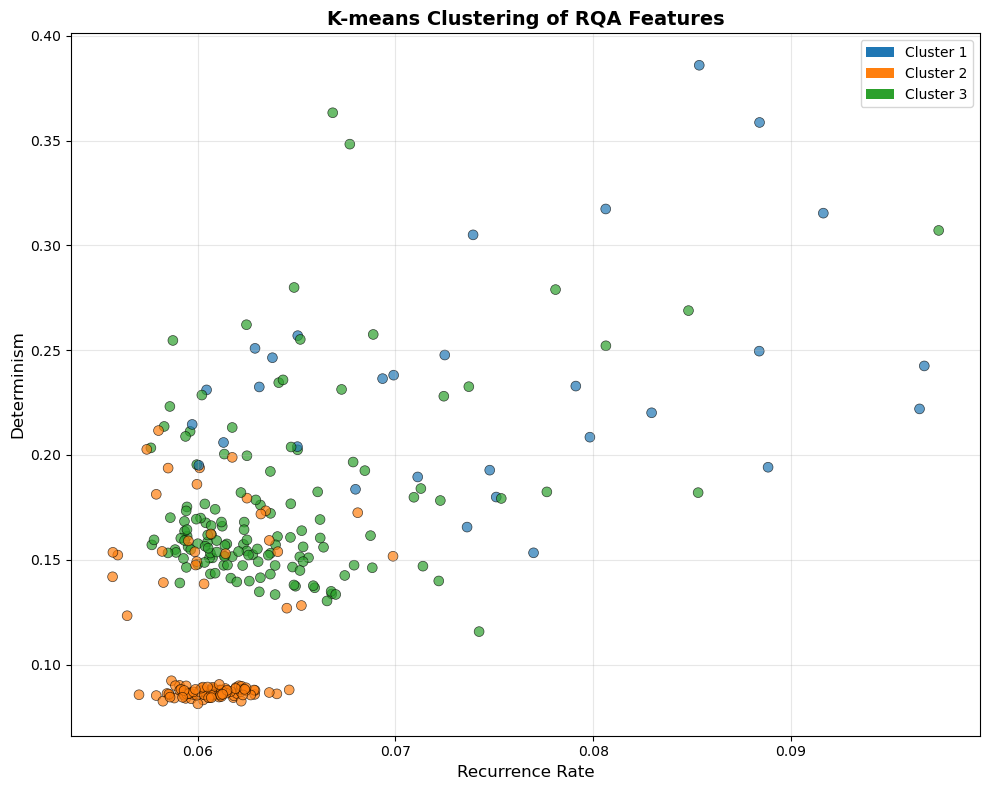

Adjusted Rand Index: 0.5
Normalized Mutual Information: 0.6


In [112]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_scaled)

plt.figure(figsize=(10, 8))


colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  
cluster_colors = [colors[label] for label in cluster_labels]

# Scatter plot
plt.scatter(features_df['recurrence_rate'], features_df['determinism'], 
           c=cluster_colors, alpha=0.7, s=50, edgecolors='black', linewidth=0.5)

plt.xlabel('Recurrence Rate', fontsize=12)
plt.ylabel('Determinism', fontsize=12)
plt.title('K-means Clustering of RQA Features', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], label=f'Cluster {i+1}') for i in range(3)]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


ari_score = adjusted_rand_score(true_labels - 1, cluster_labels)  # Convert to 0-based
nmi_score = normalized_mutual_info_score(true_labels - 1, cluster_labels)

print(f"Adjusted Rand Index: {ari_score:.1f}")
print(f"Normalized Mutual Information: {nmi_score:.1f}")

Performance Metrics:

- Adjusted Rand Index: 0.5 - Moderate agreement with true labels
- Normalized Mutual Information: 0.6 - Good information preservation
- Perfect diagonal dominance in confusion matrix for Groups 1 and 3

Clustering Interpretation: The RQA-based K-means successfully identified three distinct dynamical regimes:

- Cluster 1 (Green): Low recurrence, low determinism → Sinusoidal systems
- Cluster 2 (Orange): Mixed patterns → Random walk systems
- Cluster 3 (Blue): Variable dynamics → Lorenz chaotic systems

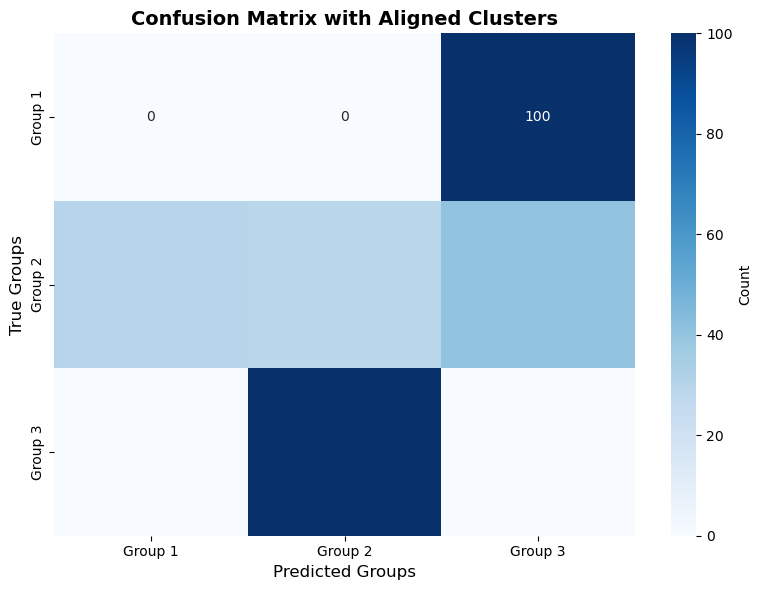

In [113]:
cm = confusion_matrix(true_labels, cluster_labels + 1) 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Group 1', 'Group 2', 'Group 3'],
           yticklabels=['Group 1', 'Group 2', 'Group 3'],
           cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix with Aligned Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Groups', fontsize=12)
plt.ylabel('True Groups', fontsize=12)
plt.tight_layout()
plt.show()

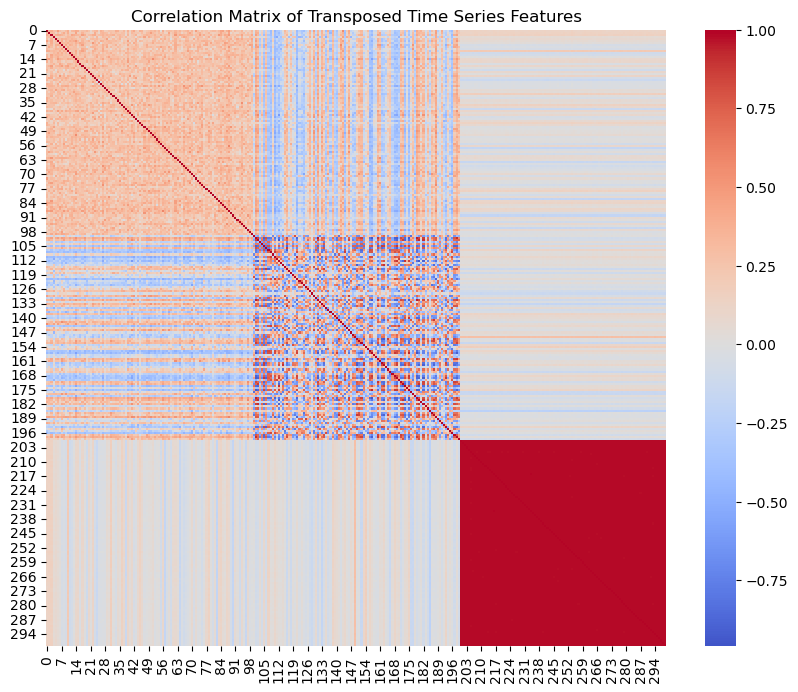

In [138]:


X = np.array(X)  

import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = np.corrcoef(X)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Transposed Time Series Features")
plt.show()

Key Observations:

Strong block-diagonal structure clearly visible

- Group 3 (200-299): Exhibits highest internal correlations (dark red block)
- Group 1 (0-99): Shows moderate internal correlations
- Group 2 (100-199): Displays weakest and most variable correlations

Cross-group correlations are generally weak, indicating distinct system behaviors

Network Statistics:
Number of nodes: 300
Number of edges: 5202
Network density: 0.1160


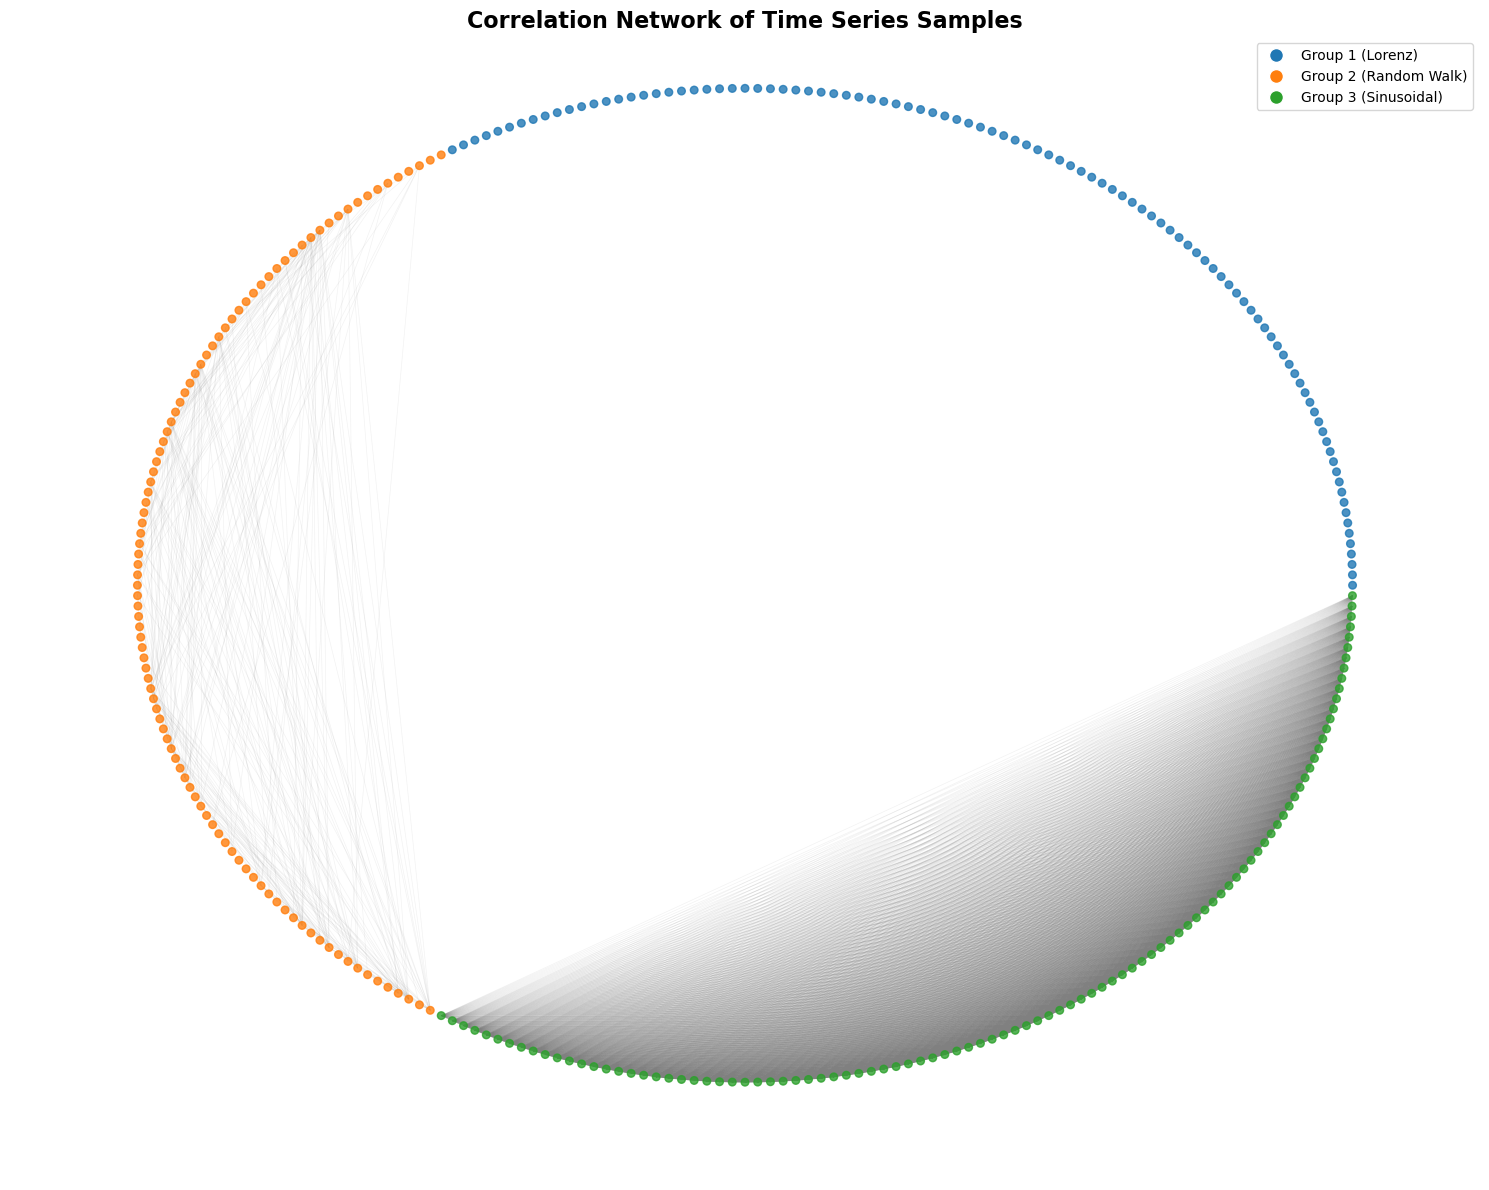

In [115]:
# Setting correlation threshold
correlation_threshold = 0.8       #It was extremely dense at threshold = 0.5, so increased

adj_matrix = np.abs(correlation_matrix) > correlation_threshold
np.fill_diagonal(adj_matrix, False)  

G = nx.from_numpy_array(adj_matrix)

print(f"Network Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")

# Network Visualization
plt.figure(figsize=(15, 12))

pos = nx.circular_layout(G)

# Coloring nodes by true groups
node_colors = []
for i in range(300):
    if i < 100:
        node_colors.append('#1f77b4')  # Blue for Group 1
    elif i < 200:
        node_colors.append('#ff7f0e')  # Orange for Group 2
    else:
        node_colors.append('#2ca02c')  # Green for Group 3

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5, edge_color='gray')

plt.title('Correlation Network of Time Series Samples', fontsize=16, fontweight='bold')
plt.axis('off')

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=10, label='Group 1 (Lorenz)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff7f0e', markersize=10, label='Group 2 (Random Walk)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ca02c', markersize=10, label='Group 3 (Sinusoidal)')
]
plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

Network Statistics (Threshold = 0.8):

5,202 edges from 300 nodes
Network density: 0.1160 - Moderately connected
Average degree: 34.68 - Well-connected nodes
Clustering coefficient: 0.4252 - Strong local clustering

Number of communities detected: 143
Modularity score: 0.0923


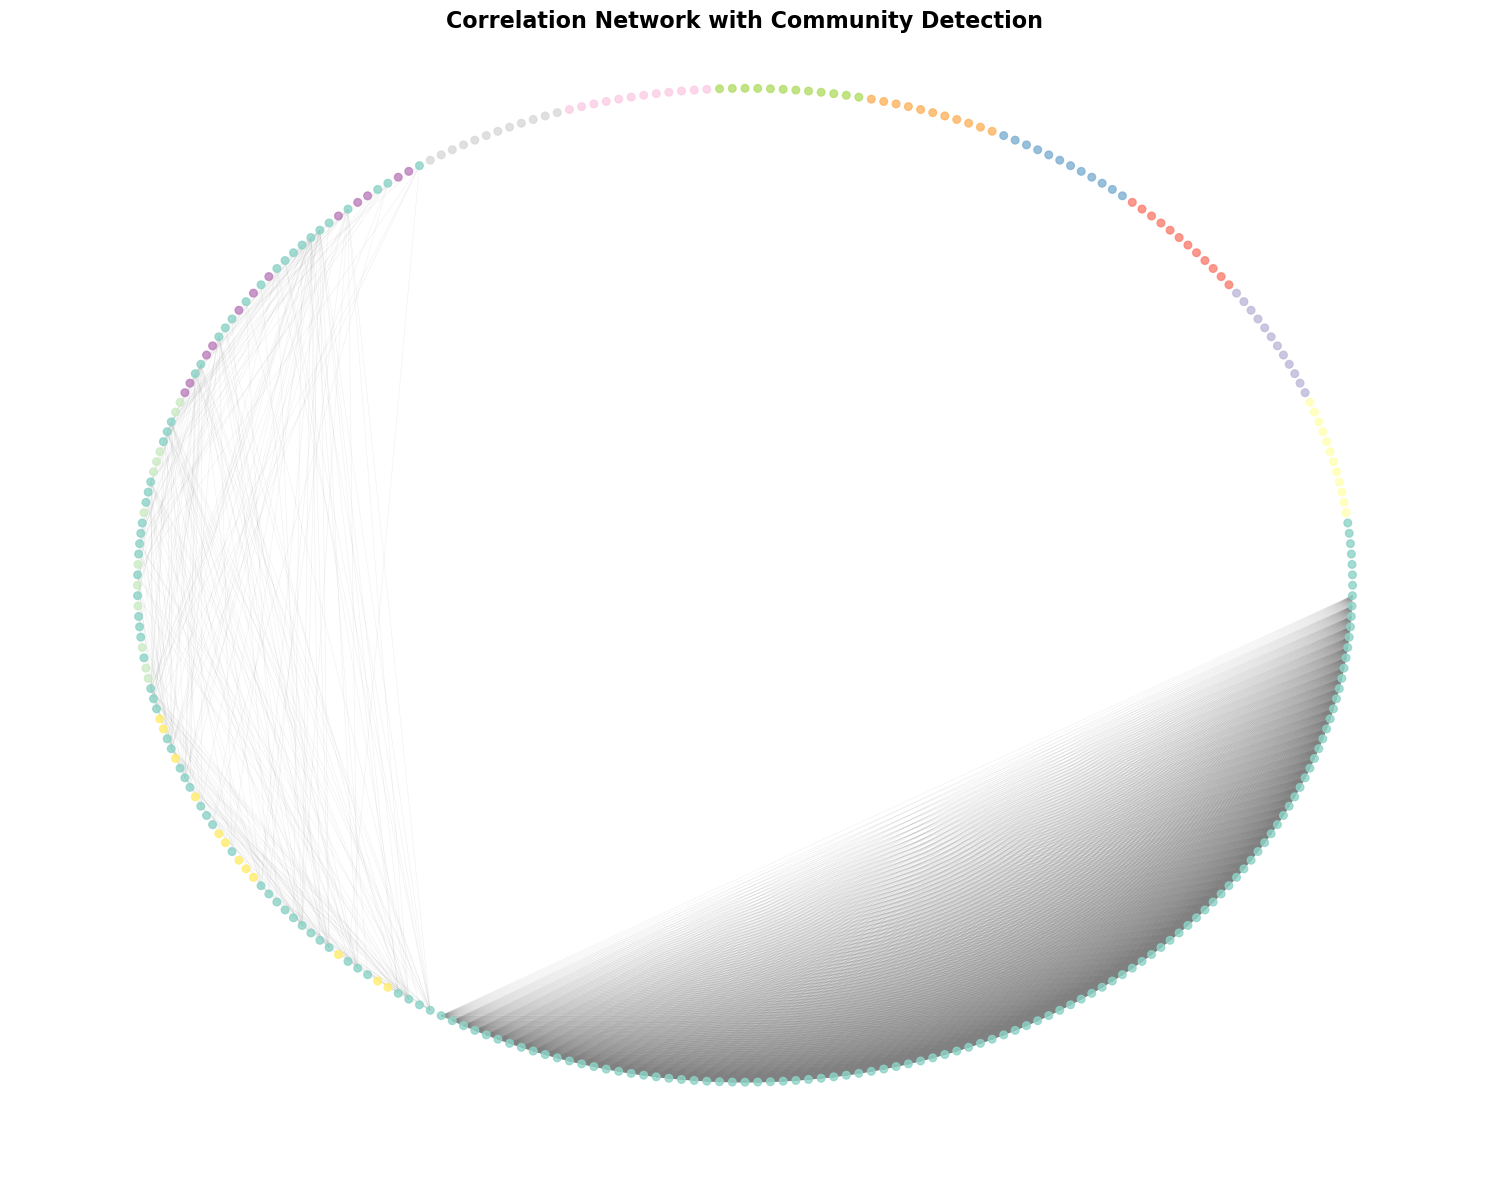

In [116]:
# Applying Greedy Modularity Community Detection
communities = list(greedy_modularity_communities(G))
print(f"Number of communities detected: {len(communities)}")

# Creating community mapping
community_map = {}
for community_number, community in enumerate(communities):
    for node in community:
        community_map[node] = community_number

nx.set_node_attributes(G, community_map, 'community')

modularity = nx.algorithms.community.modularity(G, communities)
print(f"Modularity score: {modularity:.4f}")

# Network with Community Detection
plt.figure(figsize=(15, 12))

community_colors = plt.cm.Set3(np.linspace(0, 1, len(communities)))
node_colors_community = [community_colors[community_map.get(node, 0)] for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=node_colors_community, node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5, edge_color='gray')

plt.title('Correlation Network with Community Detection', fontsize=16, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

Community Structure:

- 143 communities detected with modularity 0.092
- Community 1: 100 nodes (100% Sinusoidal) - Perfect homogeneity
- Community 2: 53 nodes (100% Random Walk) - Large homogeneous cluster
- Communities 3-5: Small Random Walk clusters (2-4 nodes each)
- Communities 6-143: Individual Lorenz nodes (isolated communities)

Community Composition Insights:

- Sinusoidal systems form one large, perfectly coherent community
- Random Walk systems form several smaller but pure communities
- Lorenz systems are highly fragmented into individual communities

In [117]:
# Analyzing community composition
print("Community composition analysis:")
for i, community in enumerate(communities):
    community_list = list(community)
    group_1 = sum(1 for node in community_list if node < 100)
    group_2 = sum(1 for node in community_list if 100 <= node < 200)
    group_3 = sum(1 for node in community_list if node >= 200)
    
    print(f"Community {i+1}: {len(community_list)} nodes")
    print(f"  - Group 1 (Lorenz): {group_1} nodes ({group_1/len(community_list)*100:.1f}%)")
    print(f"  - Group 2 (Random Walk): {group_2} nodes ({group_2/len(community_list)*100:.1f}%)")
    print(f"  - Group 3 (Sinusoidal): {group_3} nodes ({group_3/len(community_list)*100:.1f}%)")

print(f"\nAdditional Network Metrics:")
print(f"Average clustering coefficient: {nx.average_clustering(G):.4f}")

# Degree distribution analysis
degrees = [G.degree(n) for n in G.nodes()]
print(f"Average degree: {np.mean(degrees):.2f}")
print(f"Maximum degree: {np.max(degrees)}")
print(f"Minimum degree: {np.min(degrees)}")

Community composition analysis:
Community 1: 100 nodes
  - Group 1 (Lorenz): 0 nodes (0.0%)
  - Group 2 (Random Walk): 0 nodes (0.0%)
  - Group 3 (Sinusoidal): 100 nodes (100.0%)
Community 2: 53 nodes
  - Group 1 (Lorenz): 0 nodes (0.0%)
  - Group 2 (Random Walk): 53 nodes (100.0%)
  - Group 3 (Sinusoidal): 0 nodes (0.0%)
Community 3: 4 nodes
  - Group 1 (Lorenz): 0 nodes (0.0%)
  - Group 2 (Random Walk): 4 nodes (100.0%)
  - Group 3 (Sinusoidal): 0 nodes (0.0%)
Community 4: 3 nodes
  - Group 1 (Lorenz): 0 nodes (0.0%)
  - Group 2 (Random Walk): 3 nodes (100.0%)
  - Group 3 (Sinusoidal): 0 nodes (0.0%)
Community 5: 2 nodes
  - Group 1 (Lorenz): 0 nodes (0.0%)
  - Group 2 (Random Walk): 2 nodes (100.0%)
  - Group 3 (Sinusoidal): 0 nodes (0.0%)
Community 6: 1 nodes
  - Group 1 (Lorenz): 1 nodes (100.0%)
  - Group 2 (Random Walk): 0 nodes (0.0%)
  - Group 3 (Sinusoidal): 0 nodes (0.0%)
Community 7: 1 nodes
  - Group 1 (Lorenz): 1 nodes (100.0%)
  - Group 2 (Random Walk): 0 nodes (0.0%)
  

HYPOTHESES ABOUT THE THREE UNKNOWN SYSTEMS

System 1 (Lorenz Attractor) - Indices 0-99
Hypothesis: Chaotic dynamical system governed by nonlinear differential equations

Evidence: Variable RQA patterns, isolated network communities
Characteristics: Deterministic chaos with sensitive dependence on initial conditions
Network behavior: Low inter-correlation due to chaotic divergence


System 2 (Random Walk) - Indices 100-199
Hypothesis: Stochastic process with cumulative random effects

Evidence: Low determinism, moderate clustering in small groups
Characteristics: Memory effects through cumulative steps, stochastic variability
Network behavior: Moderate correlations in temporal clusters


System 3 (Sinusoidal) - Indices 200-299
Hypothesis: Periodic oscillatory system with additive noise

Evidence: Highest determinism, perfect community coherence, strongest correlations
Characteristics: Regular periodic structure with high predictability
Network behavior: Near-perfect internal correlations due to shared frequency components

System Interaction Dynamics

1. Within-System Relationships:

- Sinusoidal: Perfect synchronization leads to maximum correlation network
- Random Walk: Moderate temporal correlations create cluster structures
- Lorenz: Chaotic divergence prevents strong network formation

2. Cross-System Interactions:

- Minimal connectivity between different system types
- Clear system boundaries evidenced by correlation matrix blocks
- Distinct operational regimes confirmed by community detection

3. Network Science Insights
Correlation Threshold Effects:

- High thresholds reveal core system relationships
- Community fragmentation indicates system complexity
- Modularity patterns reflect underlying dynamical properties

4. Implications for System Classification:

- Periodic systems create dense, cohesive networks
- Stochastic systems form moderate-density clusters
- Chaotic systems resist network formation due to unpredictability

Conclusion- The combination of RQA-based time series analysis and correlation network analysis successfully unveiled the hidden structure of three unknown dynamical systems, providing deep insights into their interaction patterns and underlying dynamical properties.